In [4]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


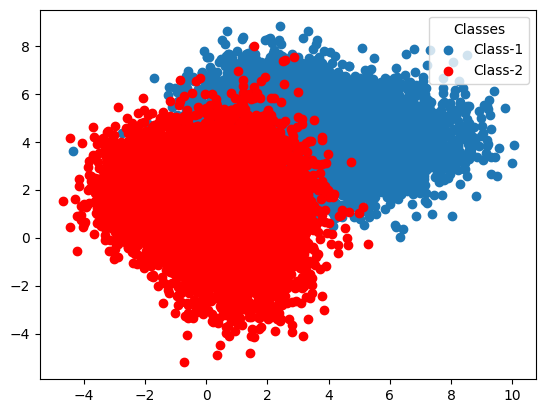

In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import roc_curve
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ExponentialLR


# hyperparameteres: activation function, unit size, iteration size
act_func_list = ["sigmoid", "tanh", "relu"]
act_func = "sigmoid"

n_hidden_l = 5

opt_list = ["adam", "sgd"]
opt = "adam"


epoch = 5
learn_r = 0.01 # we need to tune this


# load train data
c0 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/train_binary_oct22.mat')['c0']
c1 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/train_binary_oct22.mat')['c1']
c0 = c0 + 3*np.ones((3,1))

x = np.concatenate( (c0, c1), axis=1 )
x_trn = torch.from_numpy(x.T)

y = np.concatenate( (np.zeros(shape=(1, c0.shape[1])),
                     np.ones(shape=(1, c1.shape[1]))), axis=1 )
y_trn = torch.from_numpy(y.T)

d = c0.shape[0] # input feature size

# Defining input size, and output size respectively
n_in, n_out = d, 1

# plot the train data
plt.scatter(c0[0,:], c0[1,:])
plt.scatter(c1[0,:], c1[1,:], c='r')

plt.legend(("Class-1", "Class-2"), loc="upper right", title="Classes")
plt.show()


# load the test data
c0 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/test_binary_oct22.mat')['c0']
c1 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/test_binary_oct22.mat')['c1']
c0 = c0 + 3*np.ones((3,1))

x = np.concatenate( (c0, c1), axis=1 )
x_test = torch.from_numpy(x.T)
y = np.concatenate( (np.zeros(shape=(1, c0.shape[1])),
                     np.ones(shape=(1, c1.shape[1]))), axis=1 )
y_test = torch.from_numpy(y.T)




In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Create a model
class CustomModel(nn.Module):
    def __init__(self, n_in, n_hidden_l, n_out):
        super(CustomModel, self).__init__()
        self.layer1 = nn.Linear(n_in, n_hidden_l, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(n_hidden_l, n_out)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

model = CustomModel(d, n_hidden_l, 1)

# data is in double format but the model assumes float input
# you can either convert model to accept double or convert
# data to float format.
model = model.double()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

CustomModel(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:


train = data_utils.TensorDataset(x_trn, y_trn)
train_loader = data_utils.DataLoader(train, batch_size = 100, shuffle = True)

x_test = x_test.to(device)
y_test = y_test.to(device)

# Construct the loss function
# binary cross entropy
criterion = nn.BCELoss()

In [9]:

import time
from torch.utils.tensorboard import SummaryWriter

# Create a writer instance
writer = SummaryWriter('logs/experiment_1')


# Construct the optimizer (Stochastic Gradient Descent in this case)
if opt == "sgd":
   # L2 regularization is performed if weight_decay parameter is specified
   optimizer = torch.optim.SGD(model.parameters(), lr = learn_r, weight_decay=0.1)
else:
   optimizer = torch.optim.Adam(model.parameters(),lr = learn_r, betas = (0.9, 0.999))



# Initialize the ExponentialLR scheduler
gamma = 0.9  # Example gamma value
scheduler = ExponentialLR(optimizer, gamma=gamma)


start = time.time()

# Gradient Descent
iter=0
for epoch in range(epoch):

    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Forward pass: Compute predicted y by passing x to the model
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        # Compute and print loss
        loss = criterion(y_pred, y_batch)

        # add loss to logs
        writer.add_scalar('Training loss', loss, iter)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Assuming the optimizer has only one param group
        current_lr = scheduler.get_last_lr()[0]
        writer.add_scalar('Learning Rate', current_lr, iter)

        iter = iter+1

        if iter % 100 == 0:

            # convert back to the numpy format from the pytorch format
            y_pred = model(x_test)

            # Get predictions from the maximum value
            predicted = torch.round(y_pred)

            correct = (predicted == y_test).sum()
            acc = correct/y_test.shape[0]
            writer.add_scalar('Accuracy', acc, iter)

            print("Accuracy:", str(acc))

    # Step the scheduler at the end of each epoch
    scheduler.step()

end = time.time()

print(f"total time is {end-start}")

writer.close()


Accuracy: tensor(0.8384)
Accuracy: tensor(0.8580)
Accuracy: tensor(0.8618)
Accuracy: tensor(0.9108)
Accuracy: tensor(0.9222)
Accuracy: tensor(0.9240)
Accuracy: tensor(0.9264)
Accuracy: tensor(0.9226)
Accuracy: tensor(0.9263)
Accuracy: tensor(0.9280)
total time is 3.9741082191467285


In [10]:
%tensorboard --logdir logs

Output hidden; open in https://colab.research.google.com to view.